In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt

import numpy as np
import itertools
import tqdm

import skimage.transform

%matplotlib inline

In [2]:
# Размер изображения, к которому приводятся матрицы соответствия
shingle_image_size = 16

def shingles_list(s, n):
    '''
    Из строки s получаем список шинглов длиной по n символов. Сохраняем
    порядок следования шинглов.
    '''
    return [u''.join(z) for z in itertools.izip(*[s[i:] for i in range(n)])]


def get_shingle_image(str1, str2):
    '''
    Для двух заданных строк str1 и str2 строится матрица соответствия шинглов,
    затем она как прямоугольное изображение сжимается к фиксированному размеру.
    '''
    shingles1 = shingles_list(str1, 3)
    shingles2 = shingles_list(str2, 3)
    image = np.zeros((len(shingles1), len(shingles2)), dtype='float32')
    for i1, shingle1 in enumerate(shingles1):
        for i2, shingle2 in enumerate(shingles2):
            if shingle1 == shingle2:
                image[i1, i2] = 1.0

    image_resized = skimage.transform.resize(image,
                                             (shingle_image_size, shingle_image_size))
    return (image, image_resized)


def get_shingle_v(str1, str2):
    '''
    Возвращается одномерный вектор признаков
    '''
    _, img = get_shingle_image(str1, str2)
    return img.reshape(img.size)

## Посмотрим, как работает функция вычисления визуального хэша

In [3]:
image0, image1 = get_shingle_image(u'кошка отчаянно ловит серую мышку',
                                   u'серую мышку хочет поймать кошка')

C:\Users\eek\Anaconda2\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


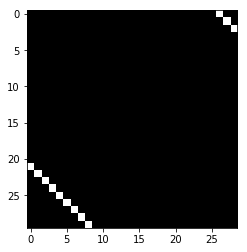

In [4]:
# полноразмерная (исходная) матрица
plt.imshow(image0, cmap='gray')

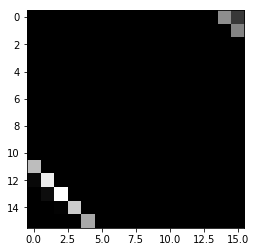

In [5]:
# после сжатия до заданного размера
plt.imshow(image1, cmap='gray')

## Получим векторы признаков для всех релевантных пар в датасете обучения модели релевантности.

In [10]:
import pandas as pd

df = pd.read_csv('../data/premise_question_relevancy.csv', encoding='utf-8', delimiter='\t', quoting=3)

vdim = shingle_image_size*shingle_image_size
X = []
samples = []
df1 = df[df['relevance']==1]
for _, row in tqdm.tqdm(df1.iterrows(), total=df1.shape[0], desc='Vectorization'):
    premise = row['premise']
    question = row['question']
    if premise != question:
        X.append(get_shingle_v(premise, question))
        samples.append((premise, question))

nb_samples = len(samples)
print('nb_samples={} vdim={}'.format(nb_samples, vdim))


Vectorization: 100%|███████████████████| 96755/96755 [01:20<00:00, 1200.79it/s]


nb_samples=67110 vdim=256


## Выполним кластеризацию этих векторов и визализируем их

In [11]:
# Теперь займемся кластеризацией полученных векторов.
import sklearn.cluster
import scipy.spatial.distance

nb_clusters = 50

kmeans = sklearn.cluster.KMeans(n_clusters=nb_clusters,
                                max_iter=20,
                                verbose=0,
                                copy_x=False,
                                n_jobs=1,
                                algorithm='auto')
kmeans.fit(X)
labels = kmeans.labels_
codebook = kmeans.cluster_centers_

In [12]:
# Визуализация получившихся кластеров.
# Для каждого кластера напечатаем несколько пар предпосылка-вопрос.
for icluster in range(nb_clusters):
    print('=== CLUSTER #{} ==='.format(icluster))
    cluster_irows = [irow for (irow, label) in enumerate(labels) if label == icluster]
    nprinted = 0
    for irow in cluster_irows:
        row = samples[irow]
        premise = row[0]
        question = row[1]
        if len(premise) < 50 and len('question') < 50:
            print(u'{:<50s} {:<50s}'.format(premise, question))
            nprinted += 1
            if nprinted > 5:
                break

    print('\n')
   

=== CLUSTER #0 ===
листья лежат на дороге слоем                       слой листьев лежит на дороге                      
приготовленный из молока коктейль                  коктейль сделанный из молока                      
суп сваренный из грибов кушаем                     кушаем суп сваренный из грибов                    
их расстреливали гаубицами                         гаубицы расстреливали их                          
они расстреливались из гаубиц                      гаубицы расстреливали их                          
ценой лучше не интересоваться                      вопрос о цене лучше не задавать                   


=== CLUSTER #1 ===
молоко коровы дают                                 коровы молоко дают                                
коровы молоко дают                                 молоко коровы дают                                
коровы траву едят                                  траву коровы едят                                 
траву коровы едят                         

листья лежат на дороге слоем                       листочки усеяли дорогу толстым слоем              
коктейль сделанный из молока                       коктейль приготовленных с использованием молока   


=== CLUSTER #13 ===
велосипед с тремя колесами                         велосипед у которого три колеса                   
велосипед на трех колесах                          велосипед у которого три колеса                   
взрослые были шокированы                           взрослые были очень сильно поражены               
кушаем суп из грибов                               кушаем суп сваренный из грибов                    
кушаем грибной суп                                 кушаем суп сваренный из грибов                    
мишин отец  космонавт                              мишин отец работает космонавтом                   


=== CLUSTER #14 ===
приготовленный из грибов суп                       суп сваренный из грибов                           
взрослые были шокированы              

факт зараждения файла довольно просто обнаружить   факт заражения файла обнаруживается довольно просто
мышке нравится сыр                                 мышке сыр нравится                                
ночью штормило                                     ночью был шторм                                   
лейтенант дисциплину любит                         лейтенанту нравится дисциплина                    


=== CLUSTER #26 ===
сделанная в японии машина                          машина сделанная в японии                         
траву коровы едят                                  едят траву коровы                                 
гремели цепи лифта                                 лифт гремел цепями                                
танечка стучала зубами                             зубы танечки стучали                              
туалет загажен кошкой                              кошка туалет загадила                             
поезд увеличивает скорость                         скорость

возмущенная ирен отходит                           ирен возмущенно отходит                           
возмутившись ирен отходит                          ирен возмущенно отходит                           
доставляется курьером                              есть доставка курьером                            
использование земли было плохим                    земля использовалась плохо                        
водолаз начал погружение                           начал водолаз погружение                          


=== CLUSTER #39 ===
приготовленный из молока коктейль                  сделанный из молока коктейль                      
приготовленный из грибов суп                       сваренный из грибов суп                           
сваренный из грибов суп                            суп с грибами                                     
мишин отец работает космонавтом                    отец мишы  космонавт                              
вводятся в японии биометрические паспорта          япония вв